# Import Packages

In [8]:
import warnings
warnings.filterwarnings("ignore")

import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from tqdm.keras import TqdmCallback
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix, mean_squared_error
import tensorflow as tf
import random as rn
import os

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
rn.seed(12345)
tf.random.set_seed(1234)

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, BatchNormalization, LSTM
from tensorflow.keras import optimizers, regularizers

# Rest of your code...


# Function Definition

# Import Data

In [9]:
df = pd.read_csv('../Dataset/crypto/BTCUSDT_data_prepared.csv').iloc[-30000:]
# df=df.drop('Unnamed: 0',1)|
df=df[['Open','High','Low','Close','Volume','SMA_indicator','close_diff_Upper_Bollinger','close_diff_Lower_Bollinger','Bollinger_indicator','true_range','date','weekday','time','close_before_1','close_before_2','close_before_3','close_before_4','close_before_5','close_before_6','close_before_7','close_before_8','close_before_9']]
df=df[~(pd.isnull(df.close_before_9))]
df=df.reset_index(drop=True)
df

,Open,High,Low,Close,Volume,SMA_indicator,close_diff_Upper_Bollinger,close_diff_Lower_Bollinger,Bollinger_indicator,true_range,...,time,close_before_1,close_before_2,close_before_3,close_before_4,close_before_5,close_before_6,close_before_7,close_before_8,close_before_9
0,11783.31,11820.61,11731.71,11801.17,2194.598589,1,-67.250029,334.028029,2.0,88.90,...,7,11783.30,11755.00,11829.99,11769.59,11665.22,11732.02,11632.91,11632.89,11599.99
1,11801.17,11857.00,11740.00,11782.63,2872.638184,1,-62.798090,253.054090,2.0,117.00,...,7,11801.17,11783.30,11755.00,11829.99,11769.59,11665.22,11732.02,11632.91,11632.89
2,11782.63,11942.55,11772.13,11942.55,3707.136801,1,48.535923,427.626077,1.0,170.42,...,7,11782.63,11801.17,11783.30,11755.00,11829.99,11769.59,11665.22,11732.02,11632.91
3,11942.54,11965.01,11892.88,11928.58,3785.415559,1,-2.012290,421.983290,2.0,72.13,...,7,11942.55,11782.63,11801.17,11783.30,11755.00,11829.99,11769.59,11665.22,11732.02
4,11928.40,12000.00,11870.00,12000.00,3746.422743,1,20.164627,508.381373,1.0,130.00,...,7,11928.58,11942.55,11782.63,11801.17,11783.30,11755.00,11829.99,11769.59,11665.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,43346.67,43753.15,43250.00,43676.07,2649.806700,0,117.920659,1192.854341,1.0,503.15,...,7,43346.68,43378.12,43176.32,43073.26,43007.74,42849.66,42763.08,43155.46,43183.74
29996,43676.07,44329.99,43608.00,44051.10,5051.478740,1,285.176673,1630.215327,1.0,721.99,...,7,43676.07,43346.68,43378.12,43176.32,43073.26,43007.74,42849.66,42763.08,43155.46
29997,44051.10,44134.80,43777.86,43915.71,2764.450380,1,20.668716,1504.474284,1.0,356.94,...,7,44051.10,43676.07,43346.68,43378.12,43176.32,43073.26,43007.74,42849.66,42763.08
29998,43915.70,44225.75,43827.69,43990.01,2510.891880,1,-37.771456,1604.275456,2.0,398.06,...,7,43915.71,44051.10,43676.07,43346.68,43378.12,43176.32,43073.26,43007.74,42849.66


In [10]:
from tqdm.keras import TqdmCallback
import tensorflow as tf
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dropout, LSTM, Dense, Activation
from tensorflow.keras import regularizers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Your utility functions
import utils

def scale_data(df_train_raw, df_val_raw):
    scaler = MinMaxScaler(feature_range=(0, 1))
    df_train_scaled = scaler.fit_transform(df_train_raw)
    df_val_scaled = scaler.transform(df_val_raw)
    return df_train_scaled, df_val_scaled, scaler

def build_model(TIME_STEPS, input_shape, lstm_units_1, lstm_units_2, hidden_units_1, hidden_units_2, input_dropout, hidden_dropout, l2_regularizer):
    model = Sequential()
    model.add(Input(batch_input_shape=(None, TIME_STEPS, input_shape)))
    model.add(Dropout(input_dropout))
    model.add(LSTM(units=lstm_units_1, return_sequences=True, kernel_initializer='random_uniform'))
    model.add(Dropout(hidden_dropout))
    model.add(LSTM(units=lstm_units_2))
    model.add(Dropout(hidden_dropout))
    model.add(Dense(hidden_units_1, kernel_regularizer=regularizers.l2(l2_regularizer), activity_regularizer=regularizers.l2(l2_regularizer)))
    model.add(Activation('relu'))
    model.add(Dropout(hidden_dropout))
    model.add(Dense(hidden_units_2, kernel_regularizer=regularizers.l2(l2_regularizer), activity_regularizer=regularizers.l2(l2_regularizer)))
    model.add(Activation('relu'))
    model.add(Dropout(hidden_dropout))
    model.add(Dense(1))
    return model

def train_model(model, x_train, y_train, x_val, y_val, BATCH_SIZE, epochs, optimizer):
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mape'])
    history = model.fit(x_train, y_train,
                        batch_size=BATCH_SIZE,
                        epochs=epochs,
                        verbose=0,
                        validation_data=(x_val, y_val),
                        callbacks=[TqdmCallback(verbose=1)])
    return history

def predict(model, x_val, BATCH_SIZE):
    y_pred = model.predict(x_val, batch_size=BATCH_SIZE)
    return y_pred.flatten()

def evaluate_predictions(y_pred, y_val, scaler):
    y_pred_org = (y_pred * scaler.data_range_[3]) + scaler.data_min_[3]
    y_val_org = (y_val * scaler.data_range_[3]) + scaler.data_min_[3]
    return y_pred_org, y_val_org

def calculate_accuracy(y_true, y_pred, window=7):
    y_pred_after = y_pred[window:]
    y_pred_before = y_pred[:-window]
    is_bullish_pred = (pd.Series(y_pred_after) - pd.Series(y_pred_before)).apply(lambda x: 1 if x > 0 else 0)

    y_true_after = y_true[window:]
    y_true_before = y_true[:-window]
    is_bullish_true = (pd.Series(y_true_after) - pd.Series(y_true_before)).apply(lambda x: 1 if x > 0 else 0)

    confusion = confusion_matrix(is_bullish_true, is_bullish_pred)
    acc = (confusion[0][0] + confusion[1][1]) / np.sum(confusion)
    return acc

def plot_results(history, y_pred_org, y_val_org):
    # Plot training & validation loss values
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot Prediction Result
    plt.figure()
    plt.plot(y_pred_org)
    plt.plot(y_val_org)
    plt.title('Prediction vs Real Asset Price')
    plt.ylabel('Price ($)')
    plt.xlabel('Timesteps')
    plt.legend(['Prediction', 'Real'], loc='upper left')
    plt.show()
    

def cross_val(df, TIME_STEPS, BATCH_SIZE, n_fold, input_dropout, hidden_dropout, l2_regularizer, lstm_units_1, lstm_units_2, hidden_units_1, hidden_units_2, optimizer, epochs):
    tscv = TimeSeriesSplit(n_splits=n_fold)
    df['target_close'] = df['Close'].shift(-1)
    mape_list, adj_mape_list, acc_list = [], [], []

    for train_index, val_index in tscv.split(df):
        print("#Train Samples: ", len(train_index), "#Val Samples: ", len(val_index))

        # Split the data into training and validation sets
        df_train_raw, df_val_raw = df.iloc[train_index, :], df.iloc[val_index, :]

        # Drop the last row from training and validation sets to avoid NaN values in the target variable
        df_train_raw = df_train_raw[:-1]
        df_val_raw = df_val_raw[:-1]

        # Extract the target variable for training and validation sets
        y_train = df_train_raw['target_close'].values
        y_val = df_val_raw['target_close'].values

        # # Drop the target variable from features
        # df_train_raw = df_train_raw.drop(columns=['target_close'])
        # df_val_raw = df_val_raw.drop(columns=['target_close'])
        
        close_index = utils.get_column_index(df_train_raw, 'target_close')

        df_train_scaled, df_val_scaled, scaler = scale_data(df_train_raw, df_val_raw)
        x_train, y_train = utils.build_timeseries(df_train_scaled, close_index, TIME_STEPS)
        x_val, y_val = utils.build_timeseries(df_val_scaled, close_index, TIME_STEPS)
        x_train, y_train = utils.trim_dataset(x_train, BATCH_SIZE), utils.trim_dataset(y_train, BATCH_SIZE)
        x_val, y_val = utils.trim_dataset(x_val, BATCH_SIZE), utils.trim_dataset(y_val, BATCH_SIZE)

        model = build_model(TIME_STEPS, x_train.shape[2], lstm_units_1, lstm_units_2, hidden_units_1, hidden_units_2, input_dropout, hidden_dropout, l2_regularizer)
        history = train_model(model, x_train, y_train, x_val, y_val, BATCH_SIZE, epochs, optimizer)
        y_pred = predict(model, x_val, BATCH_SIZE)
        y_pred_org, y_val_org = evaluate_predictions(y_pred, y_val, scaler)

        # Calculate MAPE and Adjusted MAPE
        MAPE = utils.mape(y_val_org, y_pred_org)
        mape_list.append(MAPE)
        print('Val MAPE: ', MAPE)

        adj_MAPE = utils.adjusted_mape(y_val_org, y_pred_org)
        adj_mape_list.append(adj_MAPE)
        print('Val Adjusted MAPE: ', adj_MAPE)

        # Calculate accuracy
        acc = calculate_accuracy(y_val_org, y_pred_org)
        acc_list.append(acc)
        print('Val Accuracy: ', acc)

        # Plot results
        plot_results(history, y_pred_org, y_val_org)

    print('10-Fold Accuracy Test Avg Score: {}, Std Score: {}'.format(np.mean(acc_list), np.std(acc_list)))
    print('10-Fold MAPE Test Avg Score: {}, Std Score: {}'.format(np.mean(mape_list), np.std(mape_list)))
    print('10-Fold Adjusted MAPE Test Avg Score: {}, Std Score: {}'.format(np.mean(adj_mape_list), np.std(adj_mape_list)))
    print('Epochs: {}'.format(epochs))
    print('LSTM Nodes 1: {}'.format(lstm_units_1))
    print('LSTM Nodes 2: {}'.format(lstm_units_2))
    print('Input Dropout Rate: {}'.format(input_dropout))
    print('Hidden Dropout Rate: {}'.format(hidden_dropout))
    print('Optimizer: {}'.format(optimizer))



## Hyperparameter Tuning

#Train Samples:  2730 #Val Samples:  2727


100%|██████████| 350/350 [12:33<00:00,  2.15s/epoch, loss=0.00209, mape=9.45e+3, val_loss=5.45, val_mape=54]  


108/108 [==============================] - 2s 7ms/step
Val MAPE:  39.791809086077
Val Adjusted MAPE:  29.96258582179866
Val Accuracy:  0.6843668770887487


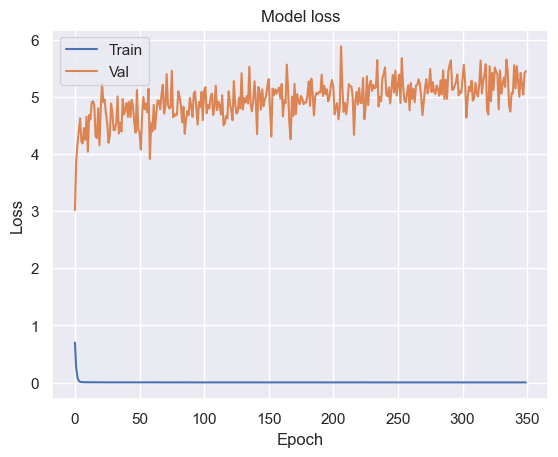

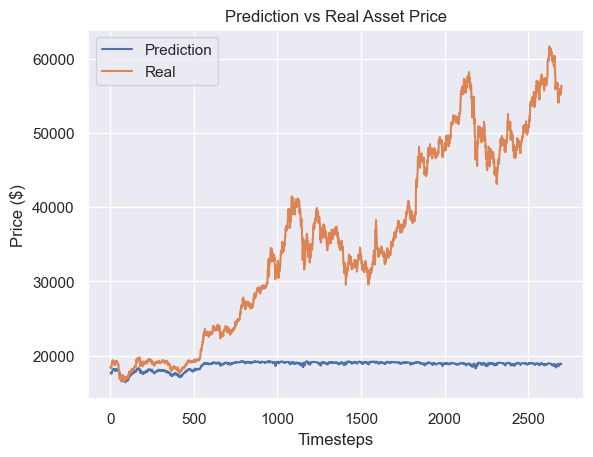

#Train Samples:  5457 #Val Samples:  2727


100%|██████████| 350/350 [20:52<00:00,  3.58s/epoch, loss=0.00247, mape=248, val_loss=0.0027, val_mape=4.66]     


108/108 [==============================] - 2s 7ms/step
Val MAPE:  3.6768930520074536
Val Adjusted MAPE:  2.8351808574545143
Val Accuracy:  0.714444857036762


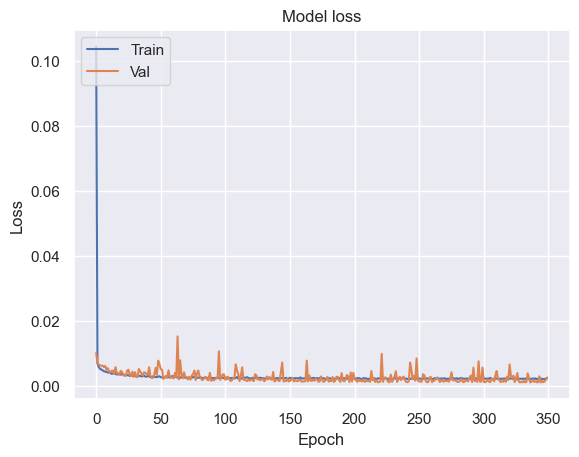

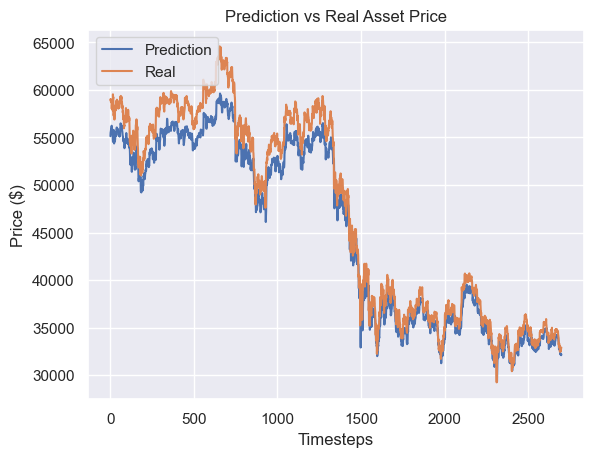

#Train Samples:  8184 #Val Samples:  2727


100%|██████████| 350/350 [32:26<00:00,  5.56s/epoch, loss=0.00271, mape=7.28e+3, val_loss=0.00117, val_mape=2.26] 


108/108 [==============================] - 2s 7ms/step
Val MAPE:  1.7605561650435502
Val Adjusted MAPE:  1.3313367701852805
Val Accuracy:  0.7070181953212031


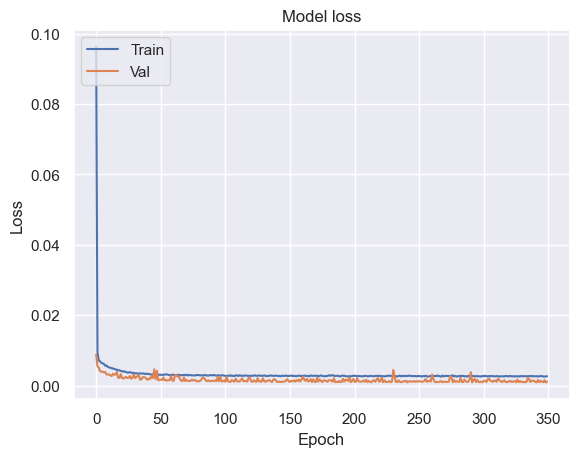

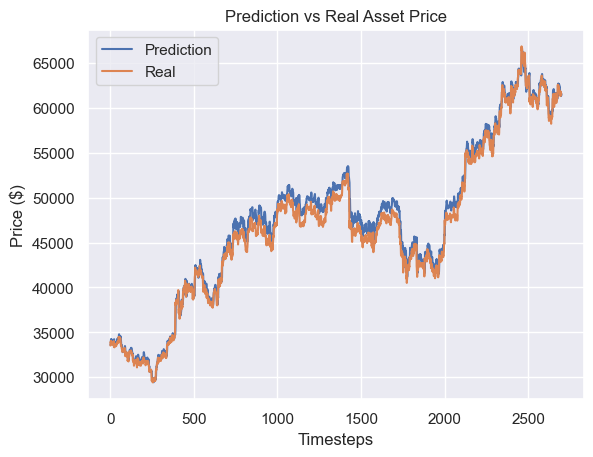

#Train Samples:  10911 #Val Samples:  2727


100%|██████████| 350/350 [39:28<00:00,  6.77s/epoch, loss=0.00249, mape=7.67e+3, val_loss=0.00161, val_mape=3.34] 


108/108 [==============================] - 2s 7ms/step
Val MAPE:  2.671821664847594
Val Adjusted MAPE:  2.0406831592558445
Val Accuracy:  0.7047901968065354


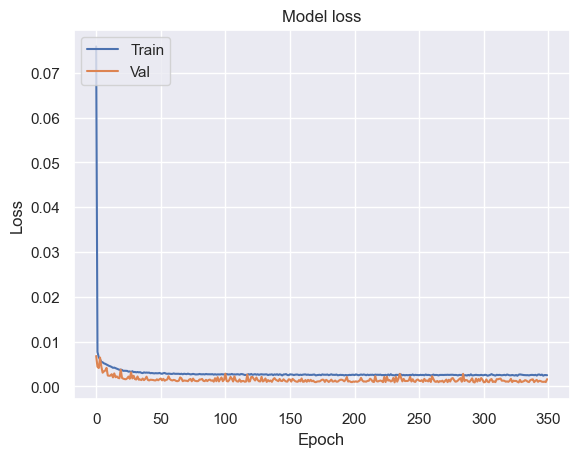

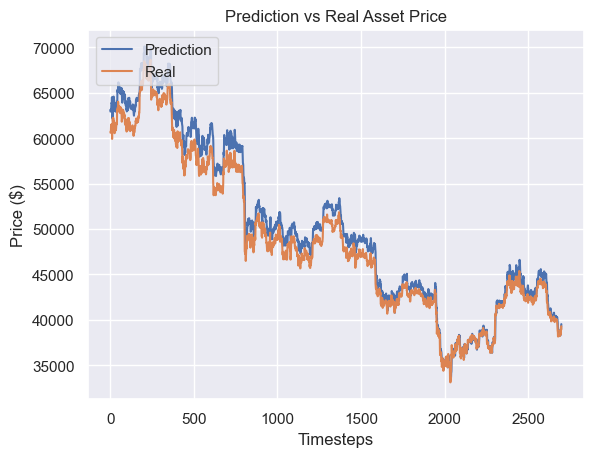

#Train Samples:  13638 #Val Samples:  2727


100%|██████████| 350/350 [47:54<00:00,  8.21s/epoch, loss=0.00238, mape=3.62e+3, val_loss=0.000817, val_mape=3.16]


108/108 [==============================] - 2s 6ms/step
Val MAPE:  2.2276477327670614
Val Adjusted MAPE:  1.678475076997317
Val Accuracy:  0.7092461938358707


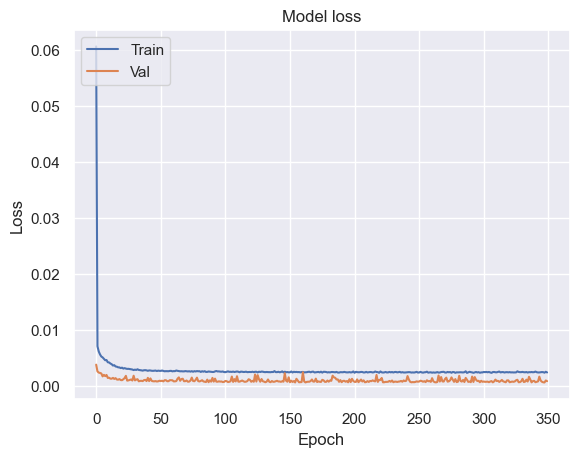

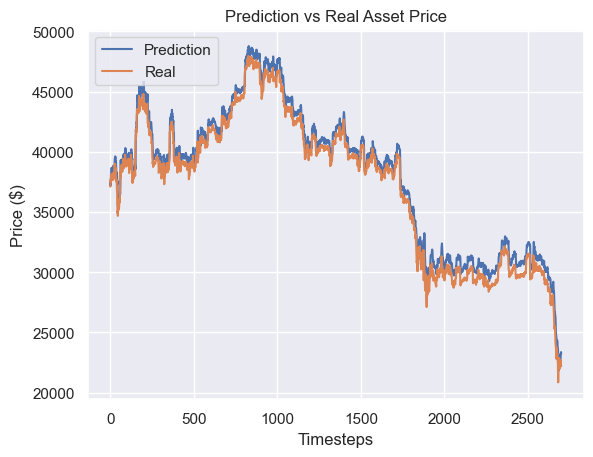

#Train Samples:  16365 #Val Samples:  2727


100%|██████████| 350/350 [54:26<00:00,  9.33s/epoch, loss=0.00224, mape=6.24e+3, val_loss=0.000729, val_mape=5.79]


108/108 [==============================] - 2s 7ms/step
Val MAPE:  3.0230685453676274
Val Adjusted MAPE:  2.3154061652481315
Val Accuracy:  0.6858522094318604


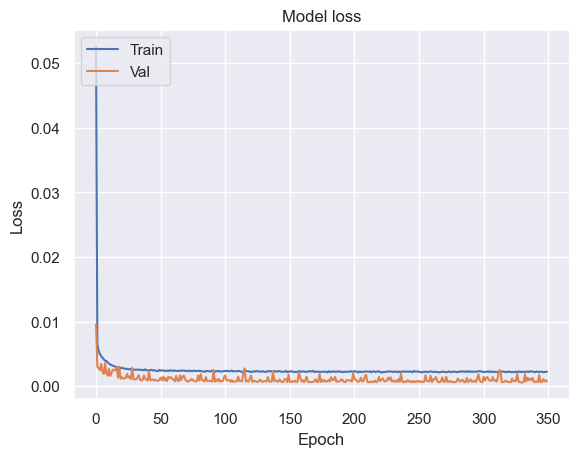

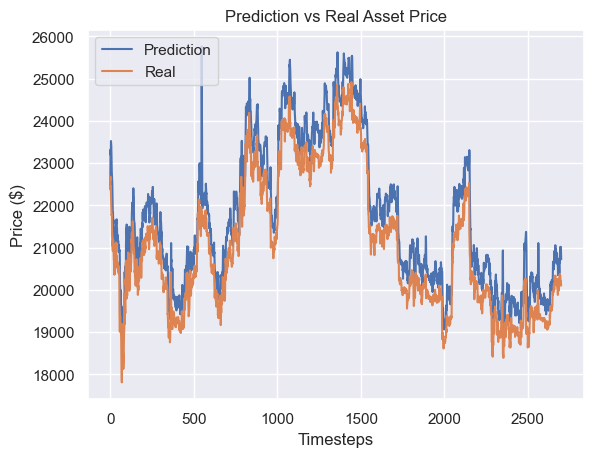

#Train Samples:  19092 #Val Samples:  2727


 94%|█████████▍| 330/350 [59:04<03:37, 10.87s/epoch, loss=0.00223, mape=67.4, val_loss=0.000821, val_mape=3.57]   

In [11]:
cross_val(df,TIME_STEPS=7,BATCH_SIZE=25,n_fold=10,
          input_dropout=0,hidden_dropout=0.2,l2_regularizer=0.005,
          lstm_units_1=256,lstm_units_2=128,
          hidden_units_1=128,hidden_units_2=64,
          optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0005),
          epochs=350)